### Предобработка датасета

Копчев Владислав

**Загрузка данных**

data: https://huggingface.co/datasets/carblacac/twitter-sentiment-analysis -> github link in description

In [1]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

In [2]:
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import nltk
# nltk.download('stopwords')

In [3]:
from nltk.util import ngrams
from nltk import word_tokenize 

In [4]:
# !pip install wordcloud
!pip install --upgrade Pillow
from wordcloud import WordCloud

In [5]:
%%time
df = pd.DataFrame(
    pd.read_csv(
        'train_150k.txt', 
        sep='\t', 
        header=None
    ).values, 
    columns=['target', 'text']
).iloc[:, [1, 0]]

**Первичный осмотр данных**

Проверка размера датасета

In [6]:
df.shape

(149985, 2)

Просмотр первых нескольких записей

In [7]:
df.head(5)

,text,target
0,Starting back at work today Looks like it'l...,0
1,Sugar levels dropping... munchies setting in. ...,1
2,@karineb22 yeah!!! have a great summer break!,1
3,hannah montana was very good. now going to re...,1
4,"@Mayra326 aww, have fun! I just had my 3D las...",1


Проверка типов данных и отсутствующих значений

In [8]:
df.dtypes

text      object
target    object
dtype: object

In [9]:
df.isna().any()

text      False
target    False
dtype: bool

**Анализ целевой переменной**

Подсчет и визуализация распределения положительных и отрицательных твитов

([<matplotlib.patches.Wedge at 0x7fab00434d00>,
 [Text(-0.0006105213261774311, 1.0999998305744008, 'Негативный класс'),
  Text(0.0006104183367606855, -1.099999830631557, 'Позитивный класс')],
 [Text(-0.0003330116324604169, 0.5999999075860367, '50.0%'),
  Text(0.00033295545641491927, -0.5999999076172129, '50.0%')])

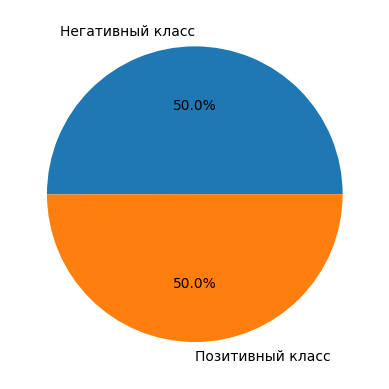

In [10]:
plt.pie([(1 - df.target).sum(), df.target.sum()], labels=['Негативный класс', 'Позитивный класс'], autopct='%1.1f%%')

**Анализ текстовых данных**

Распределение длины твитов (количество символов и слов)

In [11]:
symbols_cnt = df.text.str.len() 
words_cnt = df.text.str.count(' ') + 1

Text(0.5, 1.0, 'words hist')

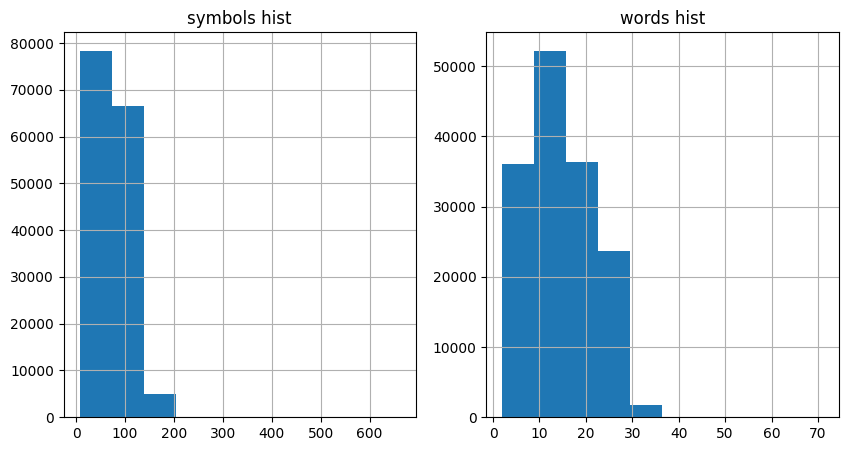

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

symbols_cnt.hist(ax=axs[0])
words_cnt.hist(ax=axs[1])

axs[0].set_title('symbols hist')
axs[1].set_title('words hist')

Частота слов: топ-20 самых частых слов для каждой тональности

In [13]:
def find_top_words(df, target_val):
    words_list = []
    for w in df.loc[df.target == target_val, 'text'].str.split().values.tolist():
        words_list += w

    word_cnt = Counter(words_list)
    top20_cnt = sorted(word_cnt.values())[-20:]

    top_cnt_words = [w for w in word_cnt if word_cnt[w] in top20_cnt]
    print(top_cnt_words)

In [14]:
find_top_words(df, 0)

['for', 'the', 'of', 'my', 'to', 'and', 'but', 'not', 'me', 'i', 'have', 'is', 'I', 'so', 'in', 'you', 'a', 'on', 'that', 'it']


In [15]:
find_top_words(df, 1)

['I', 'have', 'a', 'in', 'the', 'to', 'my', 'on', 'with', 'i', 'for', 'so', 'you', 'that', 'and', 'it', 'be', 'me', 'of', 'is']


Облака слов для положительных и отрицательных твитов

In [16]:
all_words = ' '.join(df.loc[df.target == 1, 'text'].values.tolist())

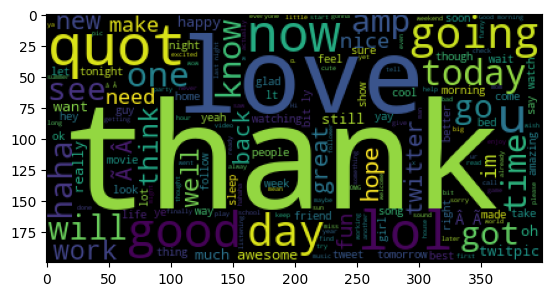

CPU times: user 2.64 s, sys: 92.2 ms, total: 2.73 s
Wall time: 2.75 s


In [20]:
%%time
plt.imshow(
    WordCloud().generate(all_words)
)
plt.show()

**Предобработка текста**

In [19]:
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_en = stopwords.words("english")
morph = MorphAnalyzer()

Токенизация

In [20]:
df = df.assign(tokens = df.text.str.split())

Удаление стоп-слов

In [21]:
%%time
df.tokens = df.tokens.apply(lambda tokens_list : list(filter(lambda x : x not in stopwords_en, tokens_list)))

CPU times: user 3.07 s, sys: 14.3 ms, total: 3.09 s
Wall time: 3.09 s


Лемматизация

In [22]:
%%time
df.tokens = df.tokens.apply(lambda tokens_list : list(map(lambda token : morph.normal_forms(token)[0], tokens_list)))

CPU times: user 17.1 s, sys: 86 ms, total: 17.2 s
Wall time: 17.2 s


**Анализ n-грамм**

Визуализация топ-20 биграмм и триграмм для каждой тональности

In [23]:
df['bigrams'] = df.tokens.apply(lambda tokens_list : list(list(ngrams(tokens_list, 2))))

In [24]:
def find_top_bigrams(df):
    words_list = []
    for w in df.loc[:, 'bigrams'].values.tolist():
        words_list += w

    word_cnt = Counter(words_list)
    top20_cnt = sorted(word_cnt.values())[-20:]

    top_cnt_words = [w for w in word_cnt if word_cnt[w] in top20_cnt]
    return {w: word_cnt[w] for w in top_cnt_words}

([<matplotlib.axis.XTick at 0x7f9b412c0820>,
 [Text(0, 0, "i'm going"),
  Text(1, 0, 'i miss'),
  Text(2, 0, 'i really'),
  Text(3, 0, 'i think'),
  Text(4, 0, 'i need'),
  Text(5, 0, 'i got'),
  Text(6, 0, 'i wish'),
  Text(7, 0, 'i like'),
  Text(8, 0, "i can't"),
  Text(9, 0, "can't wait"),
  Text(10, 0, 'wish i'),
  Text(11, 0, 'i know'),
  Text(12, 0, 'i love'),
  Text(13, 0, 'i want'),
  Text(14, 0, 'i hope'),
  Text(15, 0, 'i could'),
  Text(16, 0, 'last night'),
  Text(17, 0, 'i feel'),
  Text(18, 0, 'i hate'),
  Text(19, 0, 'i get')])

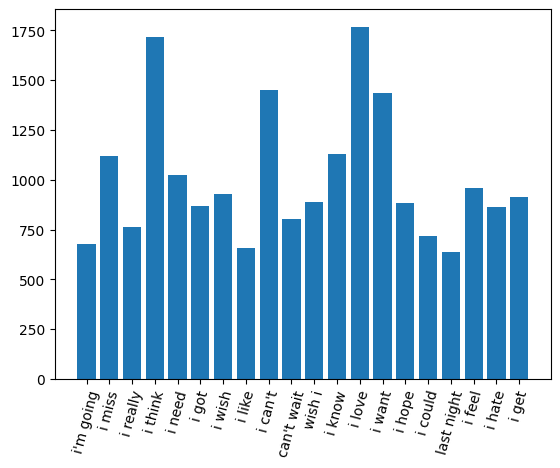

In [25]:
plt.bar(
    range(len(list(find_top_bigrams(df).values()))),
    list(find_top_bigrams(df).values()), 
    label=list(map(lambda x : ' '.join(x), find_top_bigrams(df).keys()))
)
plt.xticks(
    range(len(list(find_top_bigrams(df).values()))), 
    list(map(lambda x : ' '.join(x), find_top_bigrams(df).keys())),
    rotation=75
)

TODO 3-grams

**Анализ пунктуации и специальных символов**

Подсчет и сравнение использования восклицательных знаков, вопросительных знаков и эмодзи в положительных и отрицательных твитах

TODO emoji + придумать визуализацию поулчше

In [26]:
neg_punct = df.loc[df.target == 0, 'text'].str.count('!') + df.loc[df.target == 0, 'text'].str.count('\?')
pos_punct = df.loc[df.target == 1, 'text'].str.count('!') + df.loc[df.target == 0, 'text'].str.count('\?')

Text(0.5, 1.0, 'pos hist')

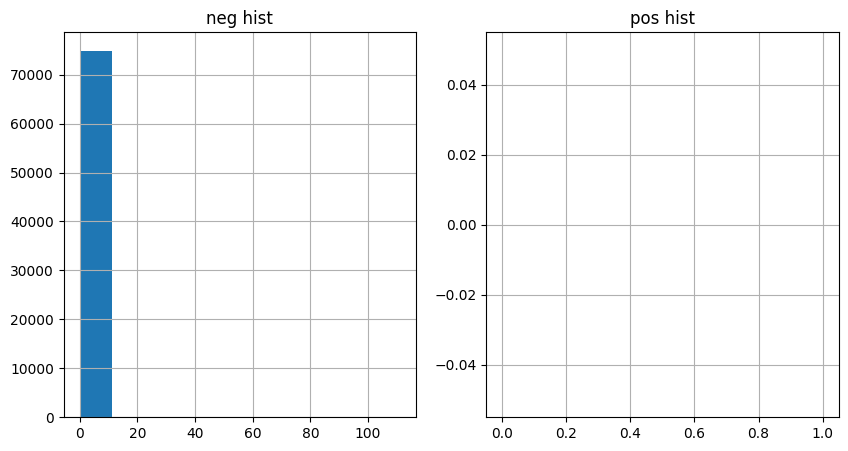

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

neg_punct.hist(ax=axs[0])
pos_punct.hist(ax=axs[1])

axs[0].set_title('neg hist')
axs[1].set_title('pos hist')

**Временной анализ (если доступны метки времени)**

Извлечение и анализ частоты хэштегов и упоминаний для каждой тональности

TODO.